## Transformer Classification Model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn

from transformers import AutoTokenizer

sns.set_theme(style="whitegrid")

C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("grouped_dataset.csv")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 


In [4]:
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_length):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        # Tokenize individual headline
        text = self.headlines[idx]
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return tokens['input_ids'].squeeze(0), torch.tensor(self.labels[idx], dtype=torch.float)
        

In [5]:
def createDataLoader(train_data, test_data, tokenizer, MAX_LENGTH, BATCH_SIZE):
    train_PYdataset = NewsDataset(
        headlines=train_data['Headlines'].tolist(),
        labels=train_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    train_dataloader = DataLoader(
        train_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )


    test_PYdataset = NewsDataset(
        headlines=test_data['Headlines'].tolist(),
        labels=test_data['trend_up'].astype(int).tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    test_dataloader = DataLoader(
        test_PYdataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    return train_dataloader, test_dataloader

In [6]:
class UntrainedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_length, num_output, dropout = 0.2):
        super(UntrainedTransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Embedding(max_length,embed_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        #
        self.linear = nn.Linear(embed_dim, num_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)

        # Token embedding + positional encoding
        x = self.embedding(input_ids) + self.positional_encoding(torch.arange(seq_length,device=input_ids.device))

        x = self.transformer(x)

        x = self.dropout(x)
        x = x.max(dim=1)[0]
        out = self.linear(x)
        return out   


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, Y in dataloader:
            input_ids = X.to(device)
            labels = Y.to(device)

            logits = model(input_ids)
            outputs = torch.sigmoid(logits).squeeze(1)


            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct / total_samples
    model.train()
    return accuracy

In [9]:
def evaluate_old(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X,Y in dataloader:
            input_ids = X.to(device)  # Move to device
            labels = Y.to(device)        # Move to device


            logits = model(input_ids)
            # Calculate predictions
            _,preds = torch.max(logits.data, 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)


    accuracy = correct / total_samples
    model.train()
    return accuracy

In [ ]:
def generateFittingGraph(train_error, test_error, epochs):
    x = range(1,epochs+1)
    plt.plot(x, train_error, label="Train Error")
    plt.plot(x, test_error, label="Test Error")
    
    plt.xlabel("Epochs")
    plt.ylabel("Predictive Error")
    plt.title("Fitting Graph")

    plt.legend()
    plt.show()



## Base Classifier Transformer Model

Epoch [1/25], Loss: 0.6769, Train Acc: 0.4352, Test Acc: 0.4692
Epoch [2/25], Loss: 0.7110, Train Acc: 0.5861, Test Acc: 0.4846
Epoch [3/25], Loss: 0.6992, Train Acc: 0.5106, Test Acc: 0.5000
Epoch [4/25], Loss: 0.5740, Train Acc: 0.4623, Test Acc: 0.4846
Epoch [5/25], Loss: 0.6894, Train Acc: 0.4352, Test Acc: 0.4692
Epoch [6/25], Loss: 0.6409, Train Acc: 0.4894, Test Acc: 0.4769
Epoch [7/25], Loss: 0.6227, Train Acc: 0.6963, Test Acc: 0.5231
Epoch [8/25], Loss: 0.6390, Train Acc: 0.8027, Test Acc: 0.5385
Epoch [9/25], Loss: 0.6437, Train Acc: 0.5977, Test Acc: 0.4462
Epoch [10/25], Loss: 0.7853, Train Acc: 0.7273, Test Acc: 0.5462
Epoch [11/25], Loss: 0.6089, Train Acc: 0.8143, Test Acc: 0.5308
Epoch [12/25], Loss: 0.5161, Train Acc: 0.9246, Test Acc: 0.5538
Epoch [13/25], Loss: 0.5743, Train Acc: 0.8008, Test Acc: 0.4923
Epoch [14/25], Loss: 0.5401, Train Acc: 0.9362, Test Acc: 0.5385
Epoch [15/25], Loss: 0.5828, Train Acc: 0.9632, Test Acc: 0.5308
Epoch [16/25], Loss: 0.4575, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


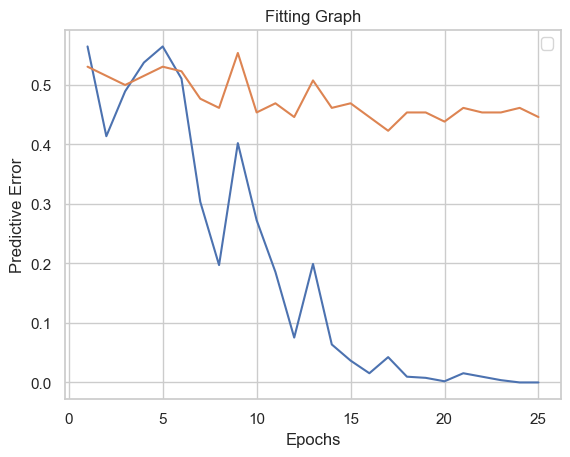

In [11]:
MAX_LENGTH = 600
BATCH_SIZE = 16
EMBED_DIM = 128
NUM_HEAD = 4
NUM_LAYER = 6
NUM_OUTPUT = 2
EPOCHS = 25
LEARNING_RATE = 1e-4

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        yb = yb.type(torch.LongTensor)
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainErr = evaluate_old(model, train_dataloader, device)    
    testErr = evaluate_old(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

## Changing to Singular Class + Adjusting Hyperparameters

Epoch [1/25], Loss: 0.6954, Train Acc: 0.5609, Test Acc: 0.5308
Epoch [2/25], Loss: 0.7111, Train Acc: 0.5571, Test Acc: 0.4846
Epoch [3/25], Loss: 0.5937, Train Acc: 0.5667, Test Acc: 0.5154
Epoch [4/25], Loss: 0.6168, Train Acc: 0.5590, Test Acc: 0.5231
Epoch [5/25], Loss: 0.5629, Train Acc: 0.5745, Test Acc: 0.5077
Epoch [6/25], Loss: 0.5367, Train Acc: 0.5667, Test Acc: 0.5308
Epoch [7/25], Loss: 0.6825, Train Acc: 0.5764, Test Acc: 0.5231
Epoch [8/25], Loss: 0.6983, Train Acc: 0.6132, Test Acc: 0.4923
Epoch [9/25], Loss: 0.6967, Train Acc: 0.5648, Test Acc: 0.5231
Epoch [10/25], Loss: 0.6917, Train Acc: 0.6151, Test Acc: 0.4923
Epoch [11/25], Loss: 0.8125, Train Acc: 0.6170, Test Acc: 0.5077
Epoch [12/25], Loss: 0.5947, Train Acc: 0.6151, Test Acc: 0.5077
Epoch [13/25], Loss: 0.5675, Train Acc: 0.5841, Test Acc: 0.5154
Epoch [14/25], Loss: 0.5799, Train Acc: 0.6654, Test Acc: 0.4923
Epoch [15/25], Loss: 0.8106, Train Acc: 0.5764, Test Acc: 0.5231
Epoch [16/25], Loss: 0.6865, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


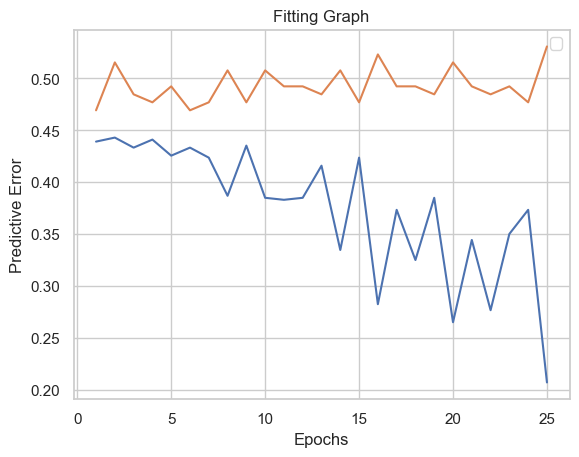

In [12]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 4
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

## Increasing number of heads

Epoch [1/25], Loss: 0.6339, Train Acc: 0.5164, Test Acc: 0.5308
Epoch [2/25], Loss: 0.7129, Train Acc: 0.5300, Test Acc: 0.4923
Epoch [3/25], Loss: 0.6841, Train Acc: 0.5377, Test Acc: 0.6077
Epoch [4/25], Loss: 0.7756, Train Acc: 0.5377, Test Acc: 0.6000
Epoch [5/25], Loss: 0.6797, Train Acc: 0.5687, Test Acc: 0.5692
Epoch [6/25], Loss: 0.6583, Train Acc: 0.5513, Test Acc: 0.6231
Epoch [7/25], Loss: 0.7730, Train Acc: 0.5513, Test Acc: 0.5923
Epoch [8/25], Loss: 0.8313, Train Acc: 0.5667, Test Acc: 0.6154
Epoch [9/25], Loss: 0.6457, Train Acc: 0.6054, Test Acc: 0.5692
Epoch [10/25], Loss: 0.6247, Train Acc: 0.5822, Test Acc: 0.6231
Epoch [11/25], Loss: 0.6272, Train Acc: 0.5822, Test Acc: 0.6154
Epoch [12/25], Loss: 0.7612, Train Acc: 0.5841, Test Acc: 0.6231
Epoch [13/25], Loss: 0.6395, Train Acc: 0.6170, Test Acc: 0.6154
Epoch [14/25], Loss: 0.7359, Train Acc: 0.6248, Test Acc: 0.6154
Epoch [15/25], Loss: 0.5890, Train Acc: 0.6596, Test Acc: 0.5923
Epoch [16/25], Loss: 0.6943, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


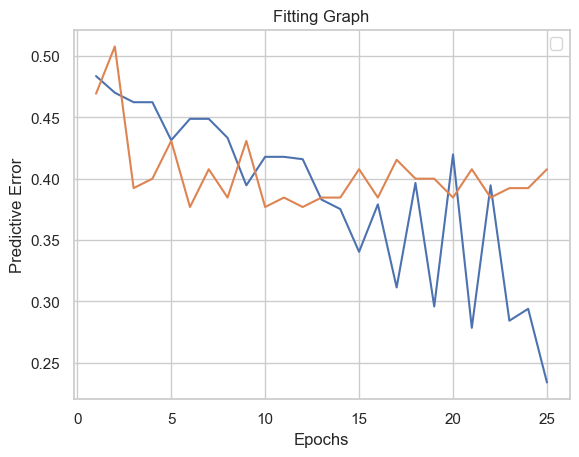

In [13]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

## Removing Specific Proper Words (remix, cramers lightning round)

In [14]:
def clean_headlines(text):
    words_to_remove = ['remix', 'cramers lightning round']

    pattern = r'\b(' + '|'.join(words_to_remove) + r')\b'
    cleaned = re.sub(pattern, '', text, flags=re.IGNORECASE)

    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

In [15]:
data_clean = data.copy()
data_clean['Headlines'] = data_clean['Headlines'].apply(clean_headlines)

Epoch [1/25], Loss: 0.7172, Train Acc: 0.5513, Test Acc: 0.5769
Epoch [2/25], Loss: 0.6653, Train Acc: 0.5648, Test Acc: 0.5538
Epoch [3/25], Loss: 0.6840, Train Acc: 0.5706, Test Acc: 0.5769
Epoch [4/25], Loss: 0.7164, Train Acc: 0.5783, Test Acc: 0.5692
Epoch [5/25], Loss: 0.6868, Train Acc: 0.5822, Test Acc: 0.5692
Epoch [6/25], Loss: 0.7180, Train Acc: 0.6054, Test Acc: 0.5846
Epoch [7/25], Loss: 0.5689, Train Acc: 0.6074, Test Acc: 0.5923
Epoch [8/25], Loss: 0.6764, Train Acc: 0.6170, Test Acc: 0.5923
Epoch [9/25], Loss: 0.6439, Train Acc: 0.6692, Test Acc: 0.5462
Epoch [10/25], Loss: 0.6882, Train Acc: 0.6460, Test Acc: 0.5923
Epoch [11/25], Loss: 0.5872, Train Acc: 0.6673, Test Acc: 0.5769
Epoch [12/25], Loss: 0.7261, Train Acc: 0.6460, Test Acc: 0.5846
Epoch [13/25], Loss: 0.6716, Train Acc: 0.7157, Test Acc: 0.5462
Epoch [14/25], Loss: 0.5474, Train Acc: 0.6770, Test Acc: 0.6000
Epoch [15/25], Loss: 0.6562, Train Acc: 0.6867, Test Acc: 0.5923
Epoch [16/25], Loss: 0.6795, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


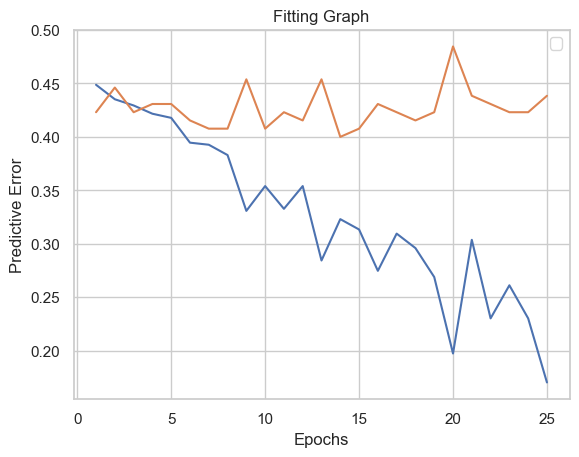

In [16]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data_clean, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

## Removing Stop Words

In [17]:
data_clean['Headlines'] = data_clean['Headlines'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
data_clean['Headlines'] = data_clean['Headlines'].apply(lambda x: [word for word in x if word not in stop_words])

i=0
for headline in data_clean['Headlines']:
    new_headline = ' '.join(headline)
    data_clean.loc[i, 'Headlines'] = new_headline
    i+=1

Epoch [1/25], Loss: 0.7095, Train Acc: 0.5474, Test Acc: 0.5231
Epoch [2/25], Loss: 0.6900, Train Acc: 0.5164, Test Acc: 0.4769
Epoch [3/25], Loss: 0.6373, Train Acc: 0.5571, Test Acc: 0.5231
Epoch [4/25], Loss: 0.6476, Train Acc: 0.5571, Test Acc: 0.5308
Epoch [5/25], Loss: 0.5742, Train Acc: 0.5764, Test Acc: 0.5231
Epoch [6/25], Loss: 0.7012, Train Acc: 0.5725, Test Acc: 0.5308
Epoch [7/25], Loss: 0.8363, Train Acc: 0.5803, Test Acc: 0.5000
Epoch [8/25], Loss: 0.6605, Train Acc: 0.6054, Test Acc: 0.5385
Epoch [9/25], Loss: 0.7665, Train Acc: 0.6074, Test Acc: 0.5154
Epoch [10/25], Loss: 0.6271, Train Acc: 0.6364, Test Acc: 0.5077
Epoch [11/25], Loss: 0.6016, Train Acc: 0.6209, Test Acc: 0.5154
Epoch [12/25], Loss: 0.6333, Train Acc: 0.6538, Test Acc: 0.5000
Epoch [13/25], Loss: 0.6575, Train Acc: 0.6228, Test Acc: 0.5231
Epoch [14/25], Loss: 0.6282, Train Acc: 0.6731, Test Acc: 0.5000
Epoch [15/25], Loss: 0.6733, Train Acc: 0.6325, Test Acc: 0.5231
Epoch [16/25], Loss: 0.6415, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


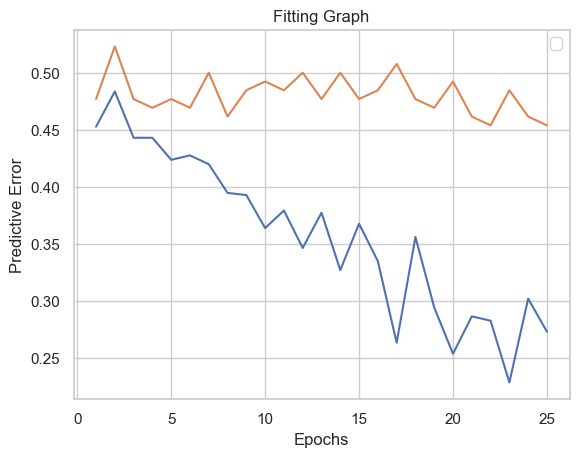

In [18]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data_clean, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)

## Adding LR Decay (Best Model)

Epoch [1/25], Loss: 0.3797, Train Acc: 0.4468, Test Acc: 0.4462
Epoch [2/25], Loss: 0.7153, Train Acc: 0.5706, Test Acc: 0.5385
Epoch [3/25], Loss: 0.5075, Train Acc: 0.5687, Test Acc: 0.5538
Epoch [4/25], Loss: 0.6603, Train Acc: 0.5764, Test Acc: 0.5462
Epoch [5/25], Loss: 0.7234, Train Acc: 0.5783, Test Acc: 0.4846
Epoch [6/25], Loss: 0.6661, Train Acc: 0.5861, Test Acc: 0.4846
Epoch [7/25], Loss: 0.6473, Train Acc: 0.5861, Test Acc: 0.5077
Epoch [8/25], Loss: 0.5911, Train Acc: 0.5861, Test Acc: 0.5154
Epoch [9/25], Loss: 0.6321, Train Acc: 0.5880, Test Acc: 0.5077
Epoch [10/25], Loss: 0.5503, Train Acc: 0.5899, Test Acc: 0.5154
Epoch [11/25], Loss: 0.4861, Train Acc: 0.5919, Test Acc: 0.5154
Epoch [12/25], Loss: 0.4942, Train Acc: 0.5957, Test Acc: 0.5308
Epoch [13/25], Loss: 0.6351, Train Acc: 0.5977, Test Acc: 0.5154
Epoch [14/25], Loss: 0.5735, Train Acc: 0.5996, Test Acc: 0.5154
Epoch [15/25], Loss: 0.6204, Train Acc: 0.5957, Test Acc: 0.5154
Epoch [16/25], Loss: 0.7306, Train

C:\Users\satvi\AppData\Local\Temp\ipykernel_23712\36210250.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


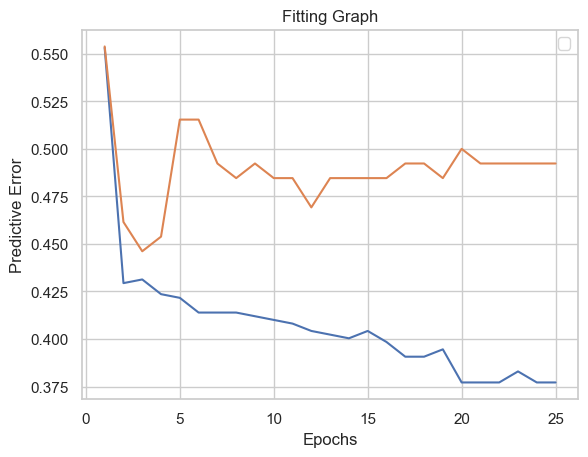

In [19]:
MAX_LENGTH = 600
BATCH_SIZE = 32
EMBED_DIM = 256
NUM_HEAD = 16
NUM_LAYER = 4
NUM_OUTPUT = 1
EPOCHS = 25
LEARNING_RATE = 1e-5

train_dataset, test_dataset = train_test_split(data, test_size=0.2, shuffle=True)
train_dataloader, test_dataloader = createDataLoader(train_dataset, test_dataset, tokenizer, MAX_LENGTH, BATCH_SIZE)

model = UntrainedTransformerClassifier(vocab_size=tokenizer.vocab_size, 
                                       embed_dim= EMBED_DIM, 
                                       num_heads= NUM_HEAD, 
                                       num_layers=NUM_LAYER, 
                                       max_length=MAX_LENGTH,
                                       num_output=NUM_OUTPUT).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

train_error = []
test_error = []

for epoch in range(EPOCHS):
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    trainErr = evaluate(model, train_dataloader, device)    
    testErr = evaluate(model, test_dataloader, device) 

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Acc: {trainErr:.4f}, Test Acc: {testErr:.4f}")

    train_error.append(1-trainErr)
    test_error.append(1-testErr)

generateFittingGraph(train_error, test_error, EPOCHS)